# Create HDF5 DataFrame for S values from alphawave FEKO files
see: http://www.h5py.org/

+ This notebook was based on `RFcalcUC_v8.py` module
+ It is used for the **TE-007** spatial averaging working group calculations

## Set up

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from collections import namedtuple
import seaborn as sn
sn.set()
%matplotlib inline

# Set current working directory to the notebook folder
%cd -0

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Functions

In [2]:
def h5store(filename, df, **kwargs):
    '''Save a DF with its metadata to a HDF5 file
       see: http://stackoverflow.com/questions/29129095/save-additional-attributes-in-pandas-dataframe
       INPUTS:
         filename = filename of the hdf5 file, including .hdf5 extension
               df = dataframe to be saved as hdf5 store
           kwargs = dict of metadata to store with the dataframe'''
    
    store = pd.HDFStore(filename)
    store.put('mydata', df)
    store.get_storer('mydata').attrs.metadata = kwargs
    store.close()

## Look at model metadata for the spatial averaging trials

In [3]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2
INPUT,,,
fMHz,MHz,900,
antenna,,IEC 62232 panel antenna,
Prad,W,80,
coordinate_origin,,centre of the middle feed segment,
xstart,m,0.5,
xend,m,14,
dx,m,0.1,
ystart,m,-7,
yend,m,7,


## Read in the E and H data from the FEKO zip files

In [4]:
# Set the trial number
trial = 1

In [5]:
# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

# Read in E-field FEKO data
print(f'{Efile = }')
Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
Edat = Edat.sort_values(['x','y','z'])
display(Edat.head())

# Read in H-field FEKO data
print(f'{Hfile = }')
Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
Hdat = Hdat.sort_values(['x','y','z'])
display(Hdat.head())

# Calculate SE, SH, Smax
SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

S = pd.DataFrame(dict(x=Edat.x,y=Edat.y,z=Edat.z,SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
S.head()

Efile = 'IEC-62232-panel-antenna-standard-mesh_Grid3DFE.efe.zip'


,x,y,z,Exr,Exi,Eyr,Eyi,Ezr,Ezi
0,0.5,-7.0,-3.0,0.002143,0.005977,0.348239,0.500341,-0.801133,-1.588188
19176,0.5,-7.0,-2.9,-0.005226,0.004985,-0.034064,0.622484,0.222759,-1.885471
38352,0.5,-7.0,-2.8,-0.008655,-0.001897,-0.386580,0.460931,1.224005,-1.515189
57528,0.5,-7.0,-2.7,-0.005113,-0.009175,-0.526968,0.137047,1.794559,-0.684281
76704,0.5,-7.0,-2.6,0.003041,-0.011303,-0.430148,-0.148068,1.809666,0.204564


Hfile = 'IEC-62232-panel-antenna-standard-mesh_Grid3DFE.hfe.zip'


,x,y,z,Hxr,Hxi,Hyr,Hyi,Hzr,Hzi
0,0.5,-7.0,-3.0,0.002329,0.004434,0.000096,0.000281,0.000050,0.000109
19176,0.5,-7.0,-2.9,-0.000593,0.005296,-0.000076,0.000306,-0.000036,0.000115
38352,0.5,-7.0,-2.8,-0.003431,0.004217,-0.000230,0.000227,-0.000097,0.000061
57528,0.5,-7.0,-2.7,-0.004992,0.001834,-0.000308,0.000084,-0.000102,-0.000014
76704,0.5,-7.0,-2.6,-0.004944,-0.000660,-0.000299,-0.000060,-0.000058,-0.000062


,x,y,z,SE,SH,Smax
0,0.5,-7.0,-3.0,0.004689,0.004748,0.004748
1,0.5,-7.0,-2.9,0.005296,0.005374,0.005374
2,0.5,-7.0,-2.8,0.005512,0.005594,0.005594
3,0.5,-7.0,-2.7,0.005286,0.005353,0.005353
4,0.5,-7.0,-2.6,0.004674,0.004708,0.004708


## Get SAR data

In [47]:
# Read in Danie's SAR data file
SARdf1 = pd.read_excel(datadir + 'wbSAR-grid-values.xlsx')
print(f'{len(SARdf1)=}')
SARdf1.agg(['min','max',len])

len(SARdf1)=455


,x,y,z,SARps,SARwb
min,0.5,0,-2,0.00000,0.00025
max,12.5,6,2,85.23636,0.80114
len,455.0,455,455,455.00000,455.00000


In [48]:
# Fill out the y<0 symmetry plane data
SARdf2 = SARdf1.copy()
SARdf2['y'] = -SARdf1.y
SARdf = pd.concat([SARdf1,SARdf2])
SARdf = SARdf.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdf = SARdf.astype({'y': 'float64','z':'float64'})

# merge SARdf with S dataframe
Sall = S.merge(SARdf,how='outer')

In [49]:
mask = ~Sall.SARwb.isna()
Sall[mask].head()

,x,y,z,SE,SH,Smax,SARps,SARwb
620,0.5,-6.0,-2.0,0.005253,0.005034,0.005253,85.23636,0.00025
630,0.5,-6.0,-1.0,0.089966,0.089332,0.089966,85.23636,0.00232
640,0.5,-6.0,0.0,0.502832,0.507044,0.507044,85.23636,0.00626
650,0.5,-6.0,1.0,0.090128,0.089491,0.090128,85.23636,0.00254
660,0.5,-6.0,2.0,0.005272,0.005051,0.005272,85.23636,0.00028


In [50]:
# Interpolate SAR values on to S grid using log-linear interpolation
SARpoints = SARdf[['x','y','z']].values
Spoints = S[['x','y','z']].values
SARwbi = 10**griddata(SARpoints, np.log10(SARdf.SARwb.values), Spoints)
Sall['SARwbi'] = SARwbi

# Replace nan's in SARwbi with -100
Sall['SARwbi'] = Sall.SARwbi.fillna(-100)

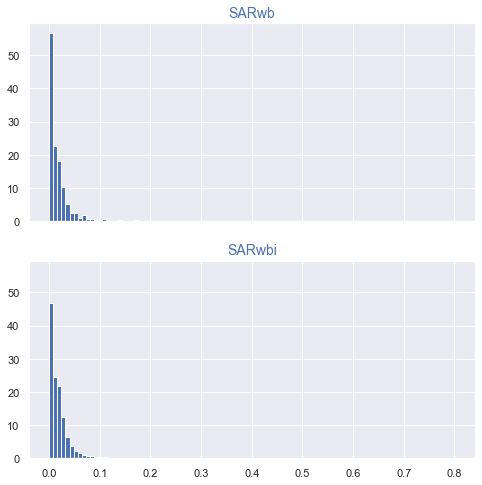

In [51]:
# Compare histogram of Danie's SARwb values with my log-linear interpolated values (SARwbi)
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
Sall.SARwb.hist(bins=100,ax=ax[0],density=True)
Sall.SARwbi[Sall.SARwbi != -100].hist(bins=100,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
# ax[0].hist(SARwb,bins=100)
# ax[1].hist(SARwbi[SARwbi != -100],bins=100)

Danie's SAR data and my interpolated data have very similar histogram distributions

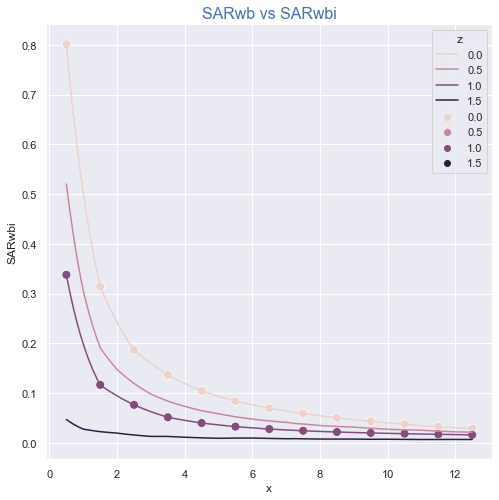

In [52]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
mask = (Sall.y == 0) & (Sall.z.isin([0,.5,1,1.5])) & (Sall.SARwbi != -100)
Sall[mask]
sn.lineplot(data=Sall[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=Sall[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b');

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

## Metadata for Sall dataframe 

In [53]:
# Create dict for S column name metadata
Snames = {'SE': 'S(E) levels',
          'SH': 'S(H) levels',
          'Smax': 'Smax levels',
          'SARps': 'peak spatial SAR',
          'SARwb': 'WBA SAR',
          'SARwbi': 'WBA SAR (interpolated)',
         }

## Save the S DataFrame as hdf5 store with metadata

In [13]:
# Set the file name of the hdf5 store
Sfile = datadir + f'{t.antenna_folder}.hdf5'

# Save the data into an hdf5 store (without x,y,z data)
Sdata = Sall.drop(columns=['x','y','z'])
h5store(Sfile, Sdata, **Snames)
print(f'S DataFrame saved to: {Sfile}')
print(f'len(S) = {len(S):,d}')

S DataFrame saved to: ../antennas/MBSpanel/data/MBSpanel.hdf5
len(S) = 1,169,736


## Display S and SAR grids

In [80]:
g = SARdf[['x','y','z']].agg(['min','max']).T
g.values.flatten().tolist()

,min,max
x,0.5,12.5
y,-6.0,6.0
z,-2.0,2.0


[0.5, 12.5, -6.0, 6.0, -2.0, 2.0]

In [62]:
# Get S and SAR grids
def n(arr):
    s = arr.unique().size
    return s

def delta(arr):
    d = np.diff(np.sort(np.unique(arr))).max()
    return d

for label, df in zip(['SAR','S'],[SARdf,S]):
    grid = df[['x','y','z']].agg(['min','max',n,delta]).T
    grid['n'] = grid.n.astype(int)
    print(f'{label} grid')
    display(grid)

SAR grid


,min,max,n,delta
x,0.5,12.5,13,1.0
y,-6.0,6.0,13,1.0
z,-2.0,2.0,5,1.0


S grid


,min,max,n,delta
x,0.5,14.0,136,0.1
y,-7.0,7.0,141,0.1
z,-3.0,3.0,61,0.1


In [63]:
def make_mgrid2(df):
    df = df.sort_values(['x','y','z'])
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    X = df.x.values.reshape(nx, ny, nz)
    Y = df.y.values.reshape(nx, ny, nz)
    Z = df.z.values.reshape(nx, ny, nz)
    return X, Y, Z, nx, ny, nz

In [82]:
X1, Y1, Z1, nx1, ny1, nz1 = make_mgrid2(SARdf)
X2, Y2, Z2, nx2, ny2, nz2 = make_mgrid2(S)

# create the Mayavi figure
from mayavi import mlab
fig = mlab.figure(1, size=(1200,900), bgcolor=(0.4, 0.4, 0.4))
mlab.clf()

# draw the grids
mlab.points3d(X2, Y2, Z2, scale_factor=0.05, color=(1,1,0), opacity=0.1)  # S grid
mlab.points3d(X1, Y1, Z1, scale_factor=0.1, color=(0,0,1), opacity=1)   # SAR grid

# Create title
title = f'SAR grid: {nx1} x {ny1} x {nz1} = {nx1*ny1*nz1} points\nS grid: {nx2} x {ny2} x {nz2} = {nx2*ny2*nz2:,} points'
mlab.title(title, height=0.85, size=0.15, color=(1,1,1))

# Draw the scene
fig.scene.parallel_projection = True
mlab.show()

## Scratch

### 3D interpolation

#### mirror values across y=0 plane

In [10]:
# Create half grid of points on +ve side of y=0 plane
x, y, z = np.mgrid[0.5:2.5, 0:2, -2:3]
p = x + y + z
df1 = pd.DataFrame(dict(x=x.flatten(),y=y.flatten(),
                       z=z.flatten(),p=p.flatten()))
df1 = df1.sort_values(['x','y','z'])

# Add other half of grid points on -ve side of y=0 plane
df2 = df1.copy()
df2['y'] = -df1.y
df3 = pd.concat([df1,df2])
df3 = df3.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)

nx, ny, nz = [df3[c].unique().size for c in df3[['x','y','z']]]
print(f'{nx=}, {ny=}, {nz=}')
display(df3)

nx=2, ny=3, nz=5


,x,y,z,p
0,0.5,-1.0,-2.0,-0.5
1,0.5,-1.0,-1.0,0.5
2,0.5,-1.0,0.0,1.5
3,0.5,-1.0,1.0,2.5
4,0.5,-1.0,2.0,3.5
5,0.5,0.0,-2.0,-1.5
6,0.5,0.0,-1.0,-0.5
7,0.5,0.0,0.0,0.5
8,0.5,0.0,1.0,1.5
9,0.5,0.0,2.0,2.5


#### Interpolate grid values

In [13]:
from scipy.interpolate import griddata
points = df3[['x','y','z']].values
xg, yg, zg = np.mgrid[0.5:1.5:11j, -1:0:11j, -2:-1:11j]
pg = griddata(points, df3.p.values, (xg,yg,zg)) 
pd.DataFrame(dict(x=xg.flatten(),y=yg.flatten(),z=zg.flatten(),p=pg.flatten()))

,x,y,z,p
0,0.5,-1.0,-2.0,-0.5
1,0.5,-1.0,-1.9,-0.4
2,0.5,-1.0,-1.8,-0.3
3,0.5,-1.0,-1.7,-0.2
4,0.5,-1.0,-1.6,-0.1
...,...,...,...,...
1326,1.5,0.0,-1.4,0.1
1327,1.5,0.0,-1.3,0.2
1328,1.5,0.0,-1.2,0.3
1329,1.5,0.0,-1.1,0.4


In [15]:
points

array([[ 0.5, -1. , -2. ],
       [ 0.5, -1. , -1. ],
       [ 0.5, -1. ,  0. ],
       [ 0.5, -1. ,  1. ],
       [ 0.5, -1. ,  2. ],
       [ 0.5,  0. , -2. ],
       [ 0.5,  0. , -1. ],
       [ 0.5,  0. ,  0. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5,  0. ,  2. ],
       [ 0.5,  1. , -2. ],
       [ 0.5,  1. , -1. ],
       [ 0.5,  1. ,  0. ],
       [ 0.5,  1. ,  1. ],
       [ 0.5,  1. ,  2. ],
       [ 1.5, -1. , -2. ],
       [ 1.5, -1. , -1. ],
       [ 1.5, -1. ,  0. ],
       [ 1.5, -1. ,  1. ],
       [ 1.5, -1. ,  2. ],
       [ 1.5,  0. , -2. ],
       [ 1.5,  0. , -1. ],
       [ 1.5,  0. ,  0. ],
       [ 1.5,  0. ,  1. ],
       [ 1.5,  0. ,  2. ],
       [ 1.5,  1. , -2. ],
       [ 1.5,  1. , -1. ],
       [ 1.5,  1. ,  0. ],
       [ 1.5,  1. ,  1. ],
       [ 1.5,  1. ,  2. ]])

### Display SAR isocontour

In [17]:
# Make the mlab grids
S['SARwb0'] = S['SARwb'].fillna(-100)
df = S
dat = 'SARwb0'
lim = 0.4
X = make_mgrid(df,'x')
Y = make_mgrid(df,'y')
Z = make_mgrid(df,'z')
F = make_mgrid(df,dat)

# create the Mayavi figure
from mayavi import mlab
fig = mlab.figure(1, size=(1200,900), bgcolor=(0.5, 0.5, 0.5))
mlab.clf()

# draw the iso-surfaces
src = mlab.pipeline.scalar_field(X, Y, Z, F, name=dat)
mlab.pipeline.iso_surface(src, contours=[lim,], opacity=0.5)
mlab.axes(x_axis_visibility=True, y_axis_visibility=True,
          z_axis_visibility=True, line_width=1)

mlab.show()

KeyError: 'SARwb'

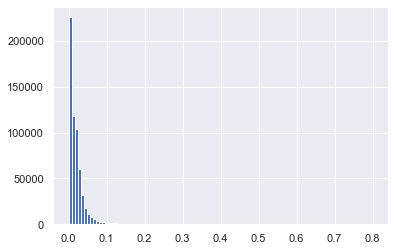

In [36]:
plt.hist(S.SARwb,bins=100);

In [44]:
S[S.y > 0].describe()

,x,y,z,SE,SH,Smax,SARwb,SARwb0
count,580720.000000,580720.000000,5.807200e+05,580720.000000,580720.000000,580720.000000,297660.000000,580720.000000
mean,7.250000,3.550000,-1.333675e-18,0.780991,0.782145,0.784960,0.019466,0.009978
std,3.925879,2.020521,1.760683e+00,1.696939,1.706812,1.715721,0.025783,0.020867
min,0.500000,0.100000,-3.000000e+00,0.001380,0.001264,0.001380,0.000250,0.000000
25%,3.875000,1.800000,-1.500000e+00,0.042500,0.042300,0.042722,0.004856,0.000000
50%,7.250000,3.550000,0.000000e+00,0.176251,0.174933,0.176722,0.013210,0.001165
75%,10.625000,5.300000,1.500000e+00,0.964717,0.964318,0.966579,0.024459,0.013719
max,14.000000,7.000000,3.000000e+00,62.056937,63.171000,63.171000,0.687289,0.687289


In [45]:
S[S.y < 0].describe()

,x,y,z,SE,SH,Smax,SARwb,SARwb0
count,580720.000000,580720.000000,5.807200e+05,580720.000000,580720.000000,580720.000000,297660.000000,580720.000000
mean,7.250000,-3.550000,-1.333675e-18,0.780943,0.782097,0.784912,0.019231,0.009857
std,3.925879,2.020521,1.760683e+00,1.696901,1.706773,1.715683,0.024191,0.019808
min,0.500000,-7.000000,-3.000000e+00,0.001382,0.001265,0.001382,0.000250,0.000000
25%,3.875000,-5.300000,-1.500000e+00,0.042497,0.042300,0.042722,0.004853,0.000000
50%,7.250000,-3.550000,0.000000e+00,0.176229,0.174910,0.176698,0.013211,0.001164
75%,10.625000,-1.800000,1.500000e+00,0.964581,0.964266,0.966480,0.024457,0.013725
max,14.000000,-0.100000,3.000000e+00,62.056738,63.170715,63.170715,0.656098,0.656098


In [ ]:
# Get S grid point data
S = SARdf
x, y, z = S.x.values, S.y.values, S.z.values
self.S[data].values.reshape(self.nx, self.ny, self.nz)
# Get SAR grid point data
s = 1

# Scale size of points appropriately for the plot
scale = 0.075

# create the Mayavi figure
mlab.figure(1, size=(1200, 900), bgcolor=(0.5, 0.5, 0.5))
mlab.clf()

mlab.points3d(x, y, z, scale_mode='none', scale_factor=scale)
self.mlabbox(self.xb, self.yb, self.zb)
title = 'Grids')
mlab.title(title, height=0.85, size=0.1)
mlab.show()
